# Bug 1849352: Throttling old Windows versions

This notebook covers analysis on crash report volumes. It proposes a throttling rule and predicts what would happen.

In [1]:
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0, 0.5, 'count')

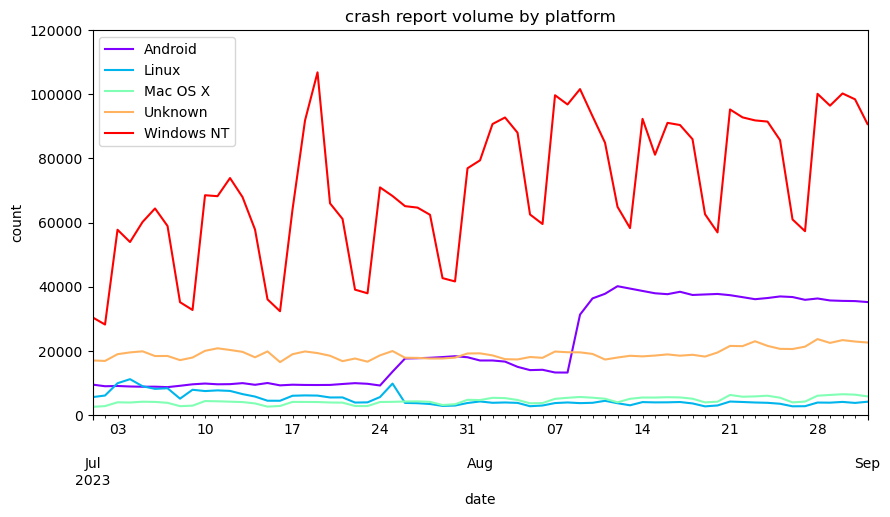

In [2]:
# Crash reports by platform across all channels
# 
# Data file is a csv with [date, list of product totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/crash_reports_by_platform.csv")
products = list(data.columns)
products.remove("date")
products.remove("--")
products.remove("total")
products.remove("0x0x000000")  # Fun with crash data!

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for product in products:
    df = data[product]
    c = next(color)
    df.plot(c=c, xlabel=product, ylabel="count", figsize=(10, 5))

plt.legend()
ax = plt.gca()
ax.set_ylim([0, 120000])
plt.title("crash report volume by platform")
plt.xlabel("date")
plt.ylabel("count")

There's a spike in crash reports from Android users around August 8th. That's a separate incident with Fenix.
We aren't going to get into that in this analysis notebook.

There's an increase in crash reports from Windows users starting around July 31st. This is the group
we're going to look at in this notebook.

Let's break down the Windows crash reports by products.

Text(0, 0.5, 'count')

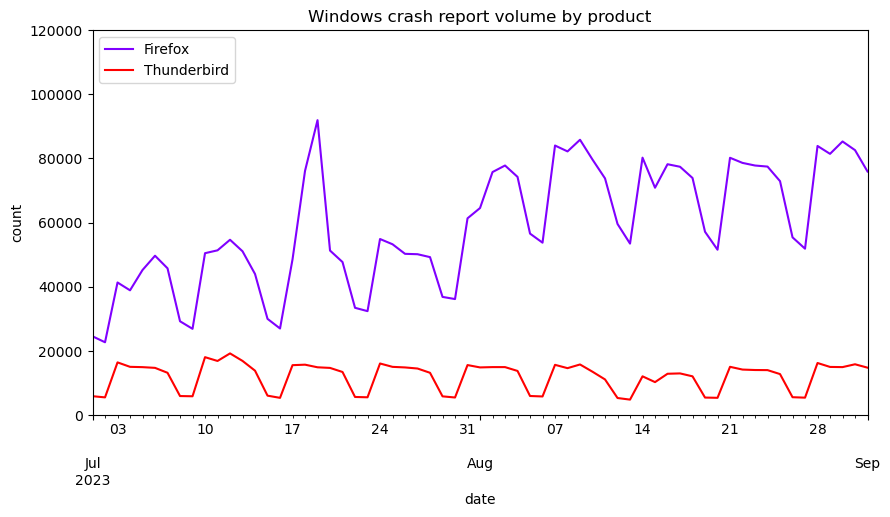

In [3]:
# Windows crash reports by product across all channels
# 
# Data file is a csv with [date, list of product totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/windows_crash_reports_by_product.csv")
products = list(data.columns)
products.remove("date")
products.remove("--")
products.remove("total")
products.remove("MozillaVPN")  # They don't really use Socorro.

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for product in products:
    df = data[product]
    c = next(color)
    df.plot(c=c, xlabel=product, ylabel="count", figsize=(10, 5))

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 120000])
plt.title("Windows crash report volume by product")
plt.xlabel("date")
plt.ylabel("count")

We get Windows crash reports for Firefox and Thunderbird, but only Firefox is affected.

Any throttling should target Firefox specifically.

Let's look at all Firefox Windows crash reports broken down by release channel.

Text(0, 0.5, 'count')

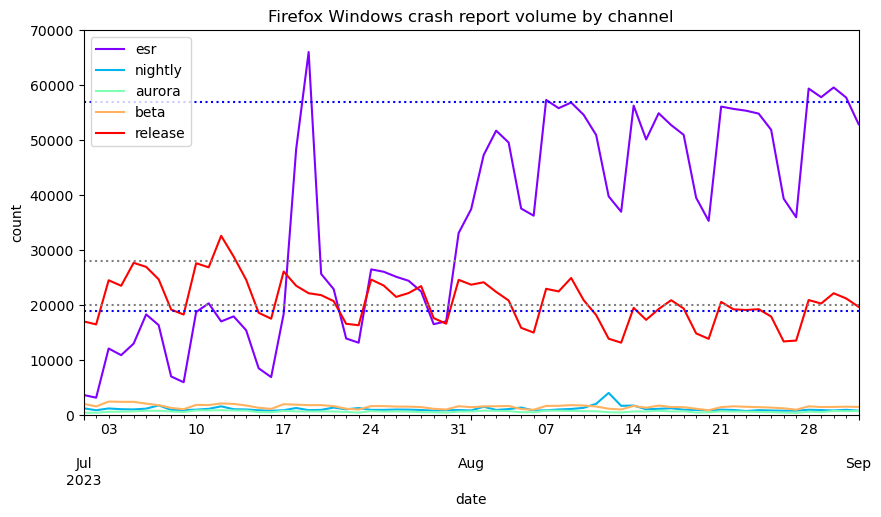

In [4]:
# Firefox Windows crash reports by channel
# 
# Data file is a csv with [date, list of channel totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/firefox_windows_crash_reports_by_channel.csv")
channels = ["esr", "nightly", "aurora", "beta", "release"]

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(channels))))

for channel in channels:
    if channel not in data:
        continue
    df = data[channel]
    c = next(color)
    df.plot(c=c, xlabel=channel, ylabel="count", figsize=(10, 5))

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 70000])

# change in release
plt.axhline(y=28000, linestyle="dotted", color="gray")
plt.axhline(y=20000, linestyle="dotted", color="gray")

# change in esr
plt.axhline(y=19000, linestyle="dotted", color="blue")
plt.axhline(y=57000, linestyle="dotted", color="blue")

plt.title("Firefox Windows crash report volume by channel")
plt.xlabel("date")
plt.ylabel("count")

Starting around July 17th, the number of crash reports for Firefox Windows users in the release channel
starts trending down and the number of crash reports for Firefox Windows users in the ESR channel
jumps significantly.

Release channel goes from roughly 28k crash reports per day to 20k crash reports per day. Thats' a decrease of 8k crash reports per day.

ESR goes from roughly 19k crash reports per day to 57k crash reports per day. That's an increase of 38k crash reports per day.

So the delta is roughly 30k crash reports per day of increased volume.

That corresponds with moving Firefox users using Windows 7/8/8.1 from release channel to ESR.

The crash ingestion pipeline throttles incoming crash reports according to a set of rules. The code is
here (March 22nd, 2023):

https://github.com/mozilla-services/antenna/blob/f72c884b9b19d8283735518270758e7de4925a57/antenna/throttler.py#L307-L401

Crash reports for Firefox Windows release channel are throttled so roughly 10% of them are accepted
and the others are rejected. We get a lot of volume from this group which is redundant and not
helpful. Throttling reduces the work our system does to collect, process, and store data and also
reduces the risk of a data breach. This is one of the things we do in our following of Lean Data Practices.

However, the ESR channel is not throttled at all. When we moved Firefox users using Windows 7/8/8.1 from release
channel (throttled) to ESR (not throttled), that represented a large jump in overall crash volume.

Let's look at Firefox Windows 7, 8, and 8.1 crash reports by channel.

Text(0, 0.5, 'count')

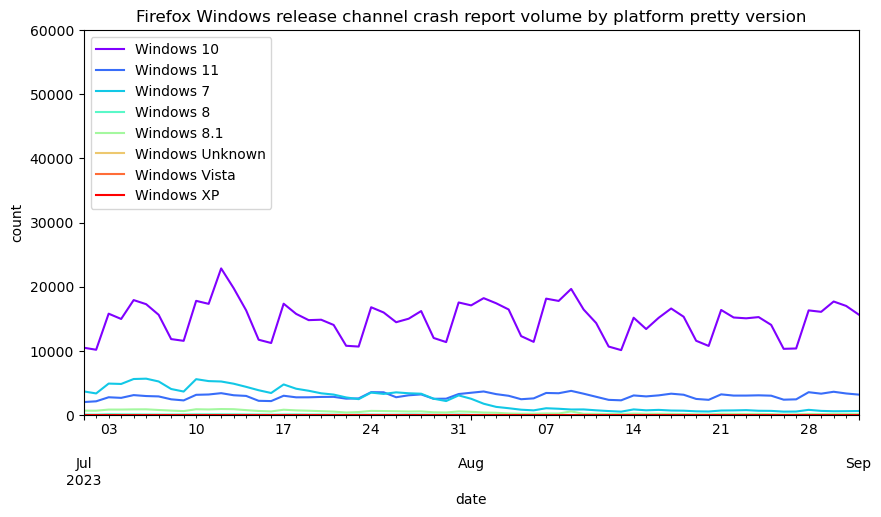

In [5]:
# Firefox Windows release channel broken down by pretty version
# 
# Data file is a csv with [date, list of channel totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/firefox_windows_release_crash_reports_by_platform.csv")
platforms = list(data.columns)
platforms.remove("date")
platforms.remove("--")
platforms.remove("total")

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(platforms))))

for platform in platforms:
    df = data[platform]
    c = next(color)
    df.plot(c=c, xlabel=platform, ylabel="count", figsize=(10, 5))

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 60000])

plt.title("Firefox Windows release channel crash report volume by platform pretty version")
plt.xlabel("date")
plt.ylabel("count")

We see movement in the Windows 7 line and a tiny bit of movement in the Windows 8.1 line.

Also, Windows XP and Windows Vista and ... Windows Unknown? Wow.

Text(0, 0.5, 'count')

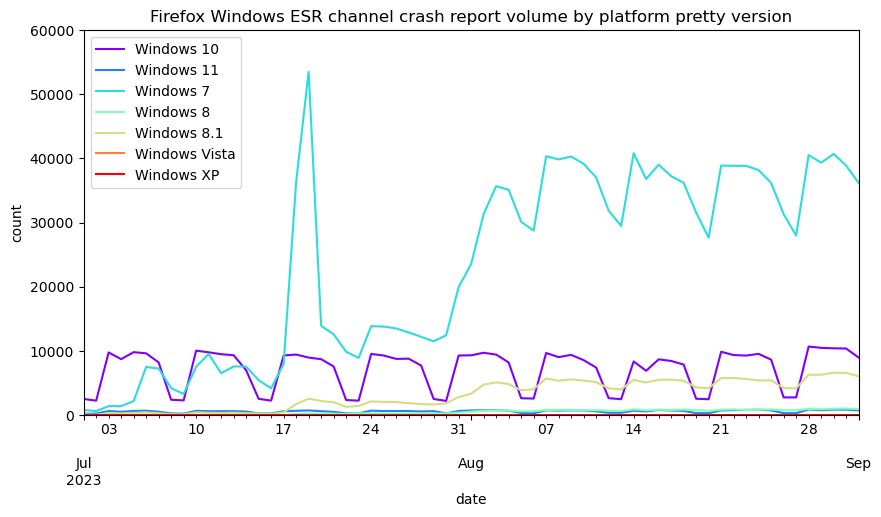

In [6]:
# Firefox Windows ESR channel broken down by pretty version
# 
# Data file is a csv with [date, list of channel totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/firefox_windows_esr_crash_reports_by_platform.csv")
platforms = list(data.columns)
platforms.remove("date")
platforms.remove("--")
platforms.remove("total")

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(platforms))))

for platform in platforms:
    df = data[platform]
    c = next(color)
    df.plot(c=c, xlabel=platform, ylabel="count", figsize=(10, 5))

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 60000])
plt.title("Firefox Windows ESR channel crash report volume by platform pretty version")
plt.xlabel("date")
plt.ylabel("count")

We see large movement in the Windows 7 line and a bit of movement in the Windows 8.1 line.

# Proposal: Throttle Firefox, ESR, Windows <= 8.1

If we throttled Firefox, ESR, Windows <= 8.1 to 25%, the crash volumes would have looked like this for ESR:

Text(0, 0.5, 'count')

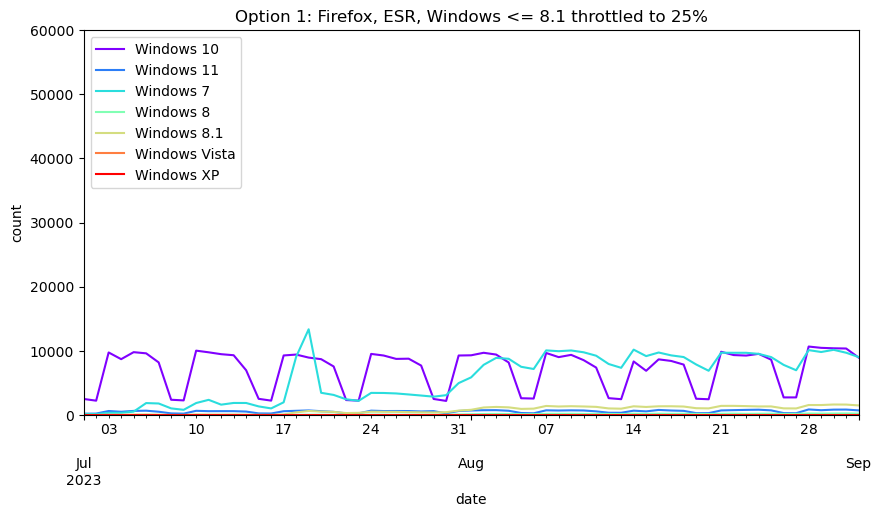

In [7]:
# Firefox, ESR, Windows <= 8.1 throttled to 25%
# 
# Data file is a csv with [date, list of channel totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1849352_data/firefox_windows_esr_crash_reports_by_platform.csv")
platforms = list(data.columns)
platforms.remove("date")
platforms.remove("--")
platforms.remove("total")

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(platforms))))

for platform in platforms:
    df = data[platform]
    # Apply throttling
    if platform in ["Windows 7", "Windows 8", "Windows 8.1"]:
        df = df * 0.25
    c = next(color)
    df.plot(c=c, xlabel=platform, ylabel="count", figsize=(10, 5))

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 60000])
plt.title("Option 1: Firefox, ESR, Windows <= 8.1 throttled to 25%")
plt.xlabel("date")
plt.ylabel("count")

That drops the crash volume for Socorro by about 30k crash reports per day.

That covers the increase in crash volume.

What are the top crashers for this group of crash reports we're going to throttle?

In [12]:
pd.read_csv("./bug_1849352_data/firefox_windows_7_esr_top_crashers.csv")


,signature,count
0,OOM | small,53363
1,OOM | large | mozalloc_abort | xul.dll | _PR_N...,18189
2,xul.dll | _PR_NativeRunThread | pr_root,10265
3,js::gc::detail::CellHasStoreBuffer,6426
4,OOM | large | xul.dll | _PR_NativeRunThread | ...,5783
5,OOM | large | __delayLoadHelper2 | _tailMerge_...,5509
6,xul.dll,5249
7,mozilla::dom::quota::QuotaManager::Shutdown::<...,4458
8,OOM | large | mozalloc_abort | xul.dll | do_main,4160
9,OOM | large | mozalloc_abort | moz_xmalloc | m...,3141


There's a lot of OOM signatures, some shutdown hangs, several signatures where we have no symbol
data (that might get fixed in [bug 1746940](https://bugzilla.mozilla.org/show_bug.cgi?id=1746940)),
and some others that exist in other platforms and channels.

# Data source

I used [crashstats-tools](https://github.com/willkg/crashstats-tools) to download crash volume counts
for a few different senarios. This data is in CSV files. The script to generate the data is here:

In [13]:
with open("./bug_1849352_data/generate_data.sh", "r") as fp:
    contents = fp.read()
print(contents)

#!/bin/bash

# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this
# file, You can obtain one at http://mozilla.org/MPL/2.0/.

rm -- *.csv

# All products by day broken down by platform
supersearchfacet \
    --_facets=platform \
    --start-date='2023-07-01' \
    --end-date='2023-09-01' \
    --period=daily \
    --format=csv \
    > crash_reports_by_platform.csv

# Windows by day broken down by product
supersearchfacet \
    --_facets=product \
    --platform=Windows \
    --start-date='2023-07-01' \
    --end-date='2023-09-01' \
    --period=daily \
    --format=csv \
    > windows_crash_reports_by_product.csv

# Firefox Windows broken down by release channel
supersearchfacet \
    --_facets=release_channel \
    --platform=Windows \
    --product=Firefox \
    --start-date='2023-07-01' \
    --end-date='2023-09-01' \
    --period=daily \
    --format=csv \
    > firefox_windows_crash_reports_by_c